In [1]:
# Load all helper functions
%run -i '../util/helper.py'

# Load and Split Data

In [2]:
# load dataset
df  = pd.read_csv('../Dataset/brazilian_ecommerce_encoded.csv')

#split dataset in features and target variable
y = df["is_delayed"]
X = df.drop(["is_delayed"], axis=1, inplace=False)

In [3]:
# split X and y into training and testing sets
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2, stratify=y)

In [4]:
print(X_dev.shape)
print(X_test.shape)

(92506, 30)
(23127, 30)


# Hyperparameter Tuning

## Stratified Sampling

### GridSearch

In [43]:
start3 = time()

parameter_grid = {'n_estimators': [230, 250, 270, 300], 'max_depth':[20, 23, 25, 27, 30] , 'warm_start': [True]}

pipe_randomforest_tune = Pipeline([('classifier', RandomForestClassifier(random_state=random_state))])
randomForestClf = RandomForestClassifier(random_state = random_state)


pipe_randomforest = make_pipeline(GridSearchCV(estimator=randomForestClf,
                                               param_grid=parameter_grid,
                                               return_train_score=True,
                                               cv=StratifiedKFold(n_splits=10,shuffle=False),
                                               n_jobs=-1, 
                                               scoring=['recall','f1'],
                                               refit='f1'))

pipe_randomforest.fit(X_dev, np.ravel(y_dev))
end3 = time()
print("Random Forest model takes " + str(end3-start3) + " seconds")
print("The performance of the Random Forest model on test data is ", pipe_randomforest.score(X_test, y_test))
grid_search_rf= pipe_randomforest.named_steps["gridsearchcv"]
print("The Random Forest model Best hyperparameters are {} ".format(grid_search_rf.best_params_))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Random Forest model takes 2151.0530779361725 seconds
The performance of the Random Forest model on test data is  0.4929925803792251
The Random Forest model Best hyperparameters are {'max_depth': 27, 'n_estimators': 270, 'warm_start': True} 


## Evaluate on Test Set

In [46]:
randomforest_prediction = pipe_randomforest.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(y_test,randomforest_prediction)))
print('Recall: {}'.format(recall_score(y_test,randomforest_prediction)))
print('Precision: {}'.format(precision_score(y_test,randomforest_prediction)))
print('F-1 Score: {}'.format(f1_score(y_test,randomforest_prediction)))

recall, precision = recall_score(y_test, randomforest_prediction), precision_score(y_test, randomforest_prediction)

Accuracy: 0.9468154105590868
Recall: 0.34308663224325875
Precision: 0.8755490483162518
F-1 Score: 0.4929925803792251


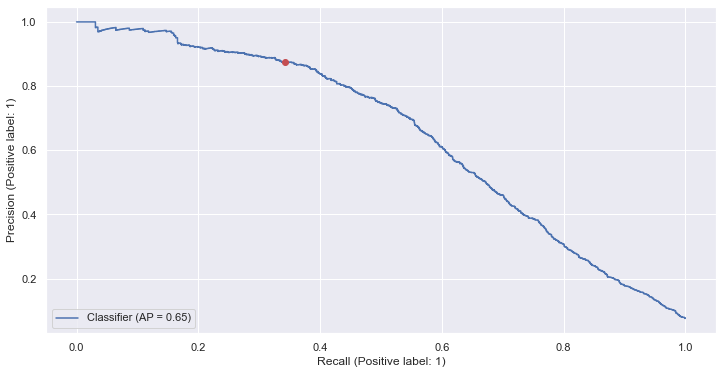

In [47]:
probs = pipe_randomforest.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall, precision,'ro');

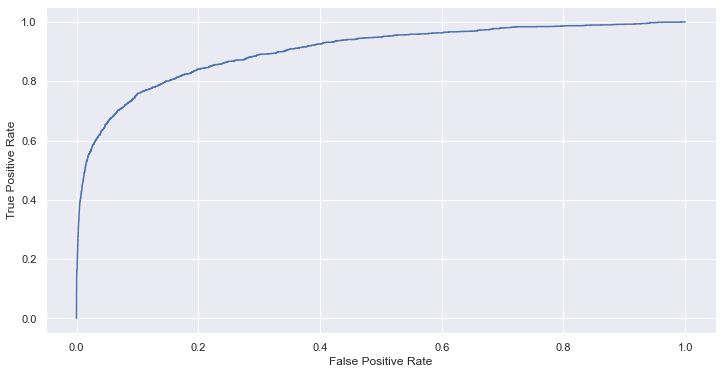

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

In [58]:
filename = '../model/RandomForest_stratified.sav'
pickle.dump(pipe_randomforest, open(filename, 'wb'))

# Downsampling

In [49]:
rus = RandomUnderSampler(replacement=False, random_state=random_state)
X_dev_us, y_dev_us = rus.fit_resample(X_dev, y_dev)

## GridSearch

In [50]:
start3 = time()

parameter_grid = {'n_estimators': [230, 250, 270, 300], 'max_depth':[20, 23, 25, 27, 30] , 'warm_start': [True]}

pipe_randomforest_tune = Pipeline([('classifier', RandomForestClassifier(random_state=random_state))])
randomForestClf = RandomForestClassifier(random_state = random_state)


pipe_randomforest_rus = make_pipeline(GridSearchCV(estimator=randomForestClf,
                                               param_grid=parameter_grid,
                                               return_train_score=True,
                                               cv=StratifiedKFold(n_splits=10,shuffle=False),
                                               n_jobs=-1, 
                                               scoring=['recall','f1'],
                                               refit='f1',
                                               verbose=5))

pipe_randomforest_rus.fit(X_dev_us, np.ravel(y_dev_us))
end3 = time()
print("Random Forest model takes " + str(end3-start3) + " seconds")
print("The performance of the Random Forest model on test data is ", pipe_randomforest_rus.score(X_test, y_test))
grid_search_rf= pipe_randomforest_rus.named_steps["gridsearchcv"]
print("The Random Forest model Best hyperparameters are {} ".format(grid_search_rf.best_params_))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Random Forest model takes 275.84513807296753 seconds
The performance of the Random Forest model on test data is  0.42144675752583494
The Random Forest model Best hyperparameters are {'max_depth': 25, 'n_estimators': 300, 'warm_start': True} 


## Evaluate on the Test Set

In [53]:
randomforest_prediction = pipe_randomforest_rus.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(y_test,randomforest_prediction)))
print('Recall: {}'.format(recall_score(y_test,randomforest_prediction)))
print('Precision: {}'.format(precision_score(y_test,randomforest_prediction)))
print('F-1 Score: {}'.format(f1_score(y_test,randomforest_prediction)))

recall, precision = recall_score(y_test, randomforest_prediction), precision_score(y_test, randomforest_prediction)

Accuracy: 0.8329657975526441
Recall: 0.8072289156626506
Precision: 0.28516416700445885
F-1 Score: 0.42144675752583494


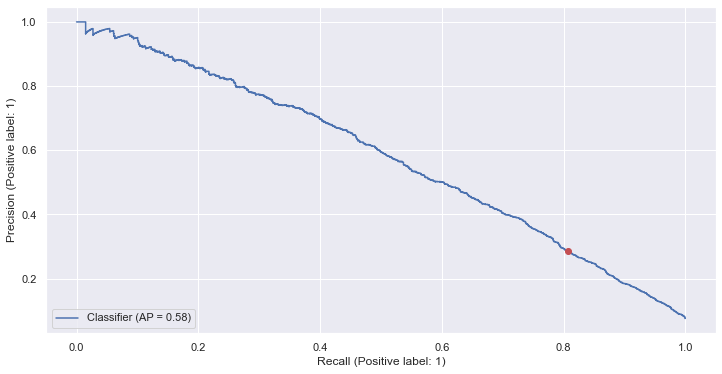

In [54]:
probs = pipe_randomforest_rus.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

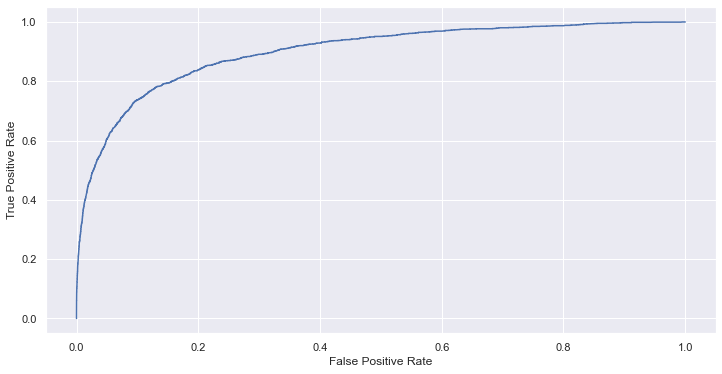

In [55]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

In [60]:
filename = '../Model/RandomForest_downsampling.sav'
pickle.dump(pipe_randomforest_rus, open(filename, 'wb'))